In [1]:
from __future__ import print_function
from __future__ import division
from builtins import str
from builtins import range
from os.path import join as opj

from nipype.interfaces.dcm2nii import Dcm2niix # to convert Dicom to Niftii


import os                                    # system functions
import sys
import nipype.interfaces.io as nio           # Data i/o
import nipype.interfaces.fsl as fsl          # fsl
import nipype.interfaces.utility as util     # utility
import nipype.pipeline.engine as pe          # pypeline engine
import nipype.algorithms.modelgen as model   # model generation
import nipype.algorithms.rapidart as ra      # artifact detection

In [2]:
# define important package paths here

sys.path.append("/home/applications/dcm2niix/build/bin")
sys.path.append("/home/applications/fsl/5.0.10/bin")
sys.path.append("/home/applications/fsl/5.0.10/etc")

In [3]:
os.environ.keys()


['LSF_EAUTH_AUX_PASS',
 'LSB_TRAPSIGS',
 'BSUB_BLOCK_EXEC_HOST',
 'SHELL',
 'LSB_DJOB_HB_INTERVAL',
 'LSB_UNIXGROUP_INT',
 'HISTSIZE',
 'LS_EXEC_T',
 'MANPATH',
 'LSB_ERRORFILE',
 'LSB_EEXEC_REAL_GID',
 'JPY_PARENT_PID',
 'FSLOUTPUTTYPE',
 'CUDA_PATH',
 'PYTHONPATH',
 'LSF_INVOKE_CMD',
 'LSB_JOBINDEX',
 'LS_JOBPID',
 'LSB_JOBID',
 'FSLGECUDAQ',
 'HOSTNAME',
 'LSB_OUTPUTFILE',
 'LSB_JOBRES_PID',
 'MNI_DIR',
 'MAIL',
 'LS_COLORS',
 'CONDA_PATH_BACKUP',
 'LSFUSER',
 'LSF_EAUTH_SERVER',
 'module',
 'LESSOPEN',
 'LSF_BINDIR',
 'CPATH',
 'USER',
 'LSF_ENVDIR',
 'HOME',
 'LSB_DJOB_NUMPROC',
 'PS1',
 'LSF_VERSION',
 'FSLTCLSH',
 'SHLVL',
 'LSB_MCPU_HOSTS',
 'FREESURFER_HOME',
 'LSB_JOBFILENAME',
 'MODULESHOME',
 'GIT_PAGER',
 'QTLIB',
 'TMPDIR',
 'MODULEPATH',
 'SSH_CONNECTION',
 'EGO_LIBDIR',
 'LSB_JOBEXIT_STAT',
 'SUBJECTS_DIR',
 '_LMFILES_',
 'PAGER',
 'MODULE_VERSION',
 'G_BROKEN_FILENAMES',
 'QTDIR',
 'LD_LIBRARY_PATH',
 'LANG',
 'LSF_SERVERDIR',
 'LSB_EXEC_CLUSTER',
 'QTINC',
 'CONDA_PRE


subject_list = ['sub-01']#, 's2', 's3', 's4', 's5'

for subs in subject_list:
    os.mkdir('/scratch/sanjay/GRT/fmri_data/nifti')
    os.mkdir('/scratch/sanjay/GRT/fmri_data/nifti/{}'.format(subs))
    os.mkdir('/scratch/sanjay/GRT/fmri_data/nifti/{}/anat'.format(subs))
    os.mkdir('/scratch/sanjay/GRT/fmri_data/nifti/{}/func'.format(subs))




sys.path.append("/home/applications/dcm2niix/build/bin")


convertnode = pe.Node(Dcm2niix(), name ='convert_dicoms')

convertnode.inputs.source_dir = '/scratch/sanjay/GRT/fmri_data/sessions/session-01/'
convertnode.inputs.output_dir = '/scratch/sanjay/GRT/fmri_data/nifti/sub-01/'
#convertnode.inputs.merge_images = True

convertnode.run()

# Data Inputs

### This is a super important section. It is where we specify the input structure for nipype. 

* going off http://nipype.readthedocs.io/en/latest/users/grabbing_and_sinking.html http://nipype.readthedocs.io/en/latest/users/examples/fmri_fsl.html
* not using the complete data set right now
* only using 1 run from the pilot
* not sure which T1 to use, we have like 2 for each session

In [4]:
data_dir = '/scratch/sanjay/GRT/fmri_data/nifti/'
output_dir = '/scratch/sanjay/GRT/fmri_data/testing/output/'
working_dir = '/scratch/sanjay/GRT/fmri_data/testing/output/working'

# list of subject identifiers
subject_list = ['sub-02']#, 's2', 's3', 's4', 's5'

task_list = ['train_', 'test_']
run_list = ['1','2','3','4','5','6']

In [5]:
#info = dict(func=[['subject_id', ['run01' ]]], struct=[['subject_id', 't1']])

infosource = pe.Node(interface=util.IdentityInterface(fields=['subject_id','task_id','run_id']),name="infosource")
infosource.iterables = [('subject_id', subject_list),('task_id',task_list ),('run_id',run_list)]

## This needs to be part of dicom convert
for i in range(1,7,1):

    os.rename('/scratch/sanjay/GRT/fmri_data/nifti/sub-02/func/train_{}.nii.gz' .format(i), '/scratch/sanjay/GRT/fmri_data/nifti/sub-02/func/sub-02_train_{}.nii.gz' .format(i)) 
    os.rename('/scratch/sanjay/GRT/fmri_data/nifti/sub-02/func/test_{}.nii.gz' .format(i), '/scratch/sanjay/GRT/fmri_data/nifti/sub-02/func/sub-02_test_{}.nii.gz' .format(i) )

### Getting Data
* read this about Data grabbing http://nipype.readthedocs.io/en/latest/users/grabbing_and_sinking.html
* and this http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html

In [6]:
# find data 

#datafind = pe.Node(interface=nio.DataFinder(root_paths = data_dir))

datasource = pe.Node(interface=nio.DataGrabber(infields=['subject_id','task_id'], outfields=['func']),
                     name='Grab_data')
datasource.inputs.base_directory = data_dir
datasource.inputs.template = '*.nii.gz'
datasource.inputs.template_args = {'func':[['subject_id','task_id']]}
datasource.inputs.field_template = dict(func='%s/func/*%s*.nii.gz')
datasource.inputs.sort_filelist = True

#### we need to connect infosource to datasource 


#results = datasource.run()

In [7]:
# Something super important is that the nifti files MUST be uncompressed for this step: nii NOT nii.gz

func_file = opj('{subject_id}', 'func',
                '{subject_id}_{task_id}{run_id}.nii') # we might have to make 3rd iterable for the runs

templates = {'func': func_file}
datasource = pe.Node(nio.SelectFiles(templates),name='Get_files')
datasource.inputs.base_directory = data_dir
#datasource.inputs.task_id = ['train_','test_']
#sf.inputs.subject_id = subject_list
#sf.run()





In [8]:
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

In [9]:
preproc = pe.Workflow(name='preproc') # this creates a pre-processing workflow of sorts. pe is pipleline engine

In [10]:
# this line takes the inputs and feeds it into the img2float conversion node


In [11]:
#extract_ref = pe.Node(interface=fsl.ExtractROI(t_size=1),name='extract_reference_volume') # this is supposed to extract middle volume of first run


In [12]:
# Define a function to pick the first file from a list of files


## Use FSL McFLIRT to do motion correction/slicetiming 

* see http://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.fsl/preprocess.html#mcflirt

In [13]:
motion_correct = pe.MapNode(interface=fsl.MCFLIRT(save_mats=True,
                                                  save_plots=True, interpolation = 'sinc'),
                            name='Realign_with_MCFLIRT',
                            iterfield=['in_file'])



In [14]:
plot_motion = pe.MapNode(interface=fsl.PlotMotionParams(in_source='fsl'),
                         name='Check_motion_plots',
                         iterfield=['in_file'])
plot_motion.iterables = ('plot_type', ['rotations', 'translations'])


In [15]:
datasink = pe.Node(nio.DataSink(), name='store_outputs')
datasink.inputs.base_directory = output_dir


preproc.connect(infosource,'subject_id',datasource, 'subject_id')
preproc.connect(infosource,'task_id',datasource, 'task_id')
preproc.connect(infosource,'run_id',datasource, 'run_id')

preproc.connect(datasource, 'func', motion_correct, 'in_file')
#preproc.connect(datasource,'func', extract_ref,'in_file')
#preproc.connect(extract_ref, 'roi_file', motion_correct, 'ref_vol') # connect the extracted middle volume to the MCFLIRT node
#preproc.connect(infosource, datasink, [('subject_id', 'container')]) # this connection might cause problems
preproc.connect(motion_correct, 'par_file', plot_motion, 'in_file')
preproc.connect(motion_correct, 'par_file', datasink,'motion.par')
preproc.connect(plot_motion, 'out_file', datasink, 'plots')

170522-15:47:28,435 workflow INFO:
	 Converting dotfile: /scratch/sanjay/GRT/fmri_data/testing/workflow_graph.dot to png format


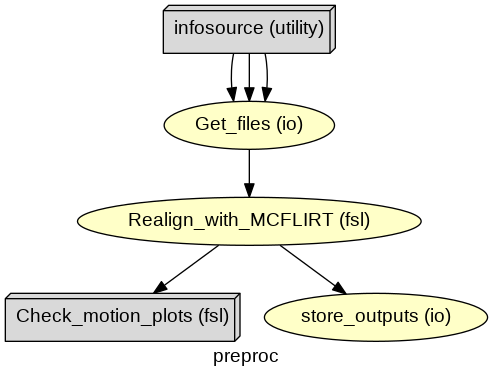

In [16]:

preproc.write_graph("workflow_graph.dot", graph2use = 'colored')
from IPython.display import Image
Image(filename="workflow_graph.dot.png")

In [17]:
preproc.run()

170522-15:47:28,472 workflow INFO:
	 ['check', 'execution', 'logging']
170522-15:47:28,681 workflow INFO:
	 Running serially.
170522-15:47:28,683 workflow INFO:
	 Executing node Get_files.b04 in dir: /scratch/afni/tmpP7sEtL/preproc/_run_id_5_subject_id_sub-02_task_id_train_/Get_files
170522-15:47:28,717 workflow INFO:
	 Runtime memory and threads stats unavailable
170522-15:47:28,720 workflow INFO:
	 Executing node Get_files.b00 in dir: /scratch/afni/tmpWCDmlQ/preproc/_run_id_1_subject_id_sub-02_task_id_train_/Get_files
170522-15:47:28,760 workflow INFO:
	 Runtime memory and threads stats unavailable
170522-15:47:28,769 workflow INFO:
	 Executing node Realign_with_MCFLIRT.b00 in dir: /scratch/afni/tmpjEZtro/preproc/_run_id_1_subject_id_sub-02_task_id_train_/Realign_with_MCFLIRT
170522-15:47:28,795 workflow INFO:
	 Executing node _Realign_with_MCFLIRT0 in dir: /scratch/afni/tmpjEZtro/preproc/_run_id_1_subject_id_sub-02_task_id_train_/Realign_with_MCFLIRT/mapflow/_Realign_with_MCFLIRT0
1

test_pipeline = pe.Workflow(name="till_motion_correct")
test_pipeline.base_dir = working_dir
test_pipeline.config = {"execution": {"crashdump_dir": working_dir }}

test_pipeline.connect([(infosource, datasource, [('subject_id', 'subject_id')]),
                    (infosource, test_pipeline, [(('subject_id', subjectinfo), 'modelfit.modelspec.subject_info')]),
                    (datasource, test_pipeline, [('struct', 'preproc.inputspec.struct'),
                                              ('func', 'preproc.inputspec.func'),
                                              ]),
                    ])